<a href="https://colab.research.google.com/github/Halakmaya/Classification-Medical-Images-Using-CNN/blob/main/ResNet101_and_EfficientnetB0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# STEP 1: MOUNT GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import random
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.resnet import preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


In [ ]:
image_size = (224, 224)  # ResNet input size
train_dir = '/content/drive/MyDrive/Dataset_BUSI_Split/train'
categories = ['benign', 'malignant', 'normal']

# Empty lists to store images and their labels
train_paths = []
train_labels = []

for label in categories:
    folder_path = os.path.join(train_dir, label)
    for image_file in os.listdir(folder_path):
        if image_file.endswith('.png'):
            train_paths.append(os.path.join(folder_path, image_file))
            train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels, random_state=42)




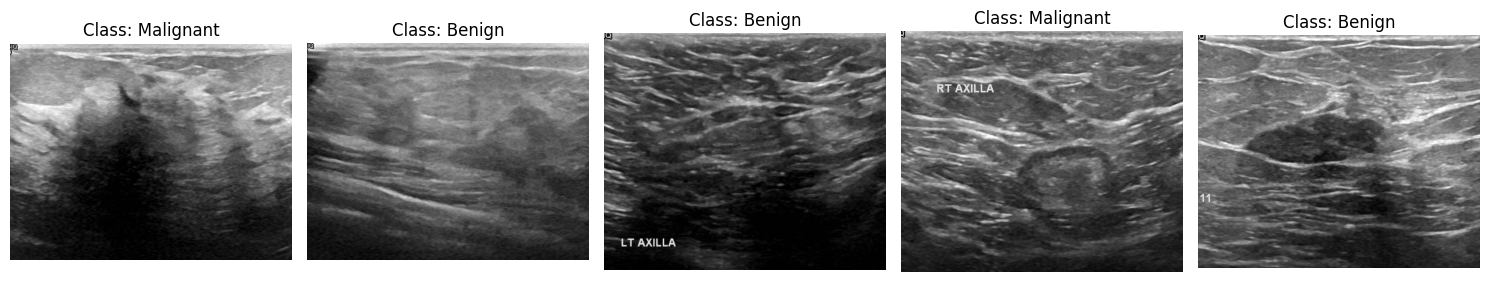

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import random

def show_images_from_paths(paths, labels, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        idx = random.randint(0, len(paths) - 1)
        img = Image.open(paths[idx])
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Class: {labels[idx].capitalize()}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_images_from_paths(train_paths, train_labels)



In [ ]:
from sklearn.model_selection import train_test_split

# Split into train and validation (85% train, 15% val)
train_paths_split, val_paths, train_labels_split, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.15, random_state=42, stratify=train_labels
)


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet import preprocess_input

image_size = (224, 224)

def load_and_preprocess_images(image_paths):
    images = []
    for path in image_paths:
        img = load_img(path, target_size=image_size)
        img_array = img_to_array(img)
        img_array = preprocess_input(img_array)
        images.append(img_array)
    return np.array(images)

# Load and preprocess the image data
X_train = load_and_preprocess_images(train_paths_split)
X_val = load_and_preprocess_images(val_paths)

# Convert text labels into numeric class indices
label_dict = {'benign': 0, 'malignant': 1, 'normal': 2}
y_train = np.array([label_dict[label] for label in train_labels_split])
y_val = np.array([label_dict[label] for label in val_labels])


In [ ]:
from PIL import ImageEnhance, ImageOps
import numpy as np
from tqdm import tqdm

augmented_images = []
augmented_labels = []

for i in tqdm(range(len(train_paths_split))):
    # Load the original image
    img = Image.open(train_paths_split[i]).convert('RGB')
    label = train_labels_split[i]

    # Resize
    img = img.resize((224, 224))

    # 1. Original
    augmented_images.append(preprocess_input(np.array(img)))
    augmented_labels.append(label_dict[label])

    # 2. Brightness enhancement
    enhancer = ImageEnhance.Brightness(img)
    bright_img = enhancer.enhance(1.5)
    augmented_images.append(preprocess_input(np.array(bright_img)))
    augmented_labels.append(label_dict[label])

    # 3. Contrast enhancement
    enhancer = ImageEnhance.Contrast(img)
    contrast_img = enhancer.enhance(1.3)
    augmented_images.append(preprocess_input(np.array(contrast_img)))
    augmented_labels.append(label_dict[label])

    # 4. Rotation
    rotated_img = img.rotate(20)
    augmented_images.append(preprocess_input(np.array(rotated_img)))
    augmented_labels.append(label_dict[label])

    # 5. Horizontal Flip
    flipped_img = ImageOps.mirror(img)
    augmented_images.append(preprocess_input(np.array(flipped_img)))
    augmented_labels.append(label_dict[label])

X_train_augmented = np.array(augmented_images)
y_train_augmented = np.array(augmented_labels)


100%|██████████| 562/562 [00:14<00:00, 38.79it/s]


In [ ]:
# Load and preprocess validation images (no augmentation)
val_images = []

for path in tqdm(val_paths):
    img = Image.open(path).convert('RGB')  # Make sure it's 3 channels
    img = img.resize((224, 224))
    img_array = np.array(img)
    img_array = preprocess_input(img_array)
    val_images.append(img_array)

X_val = np.array(val_images)
y_val = np.array([label_dict[label] for label in val_labels])


100%|██████████| 100/100 [00:01<00:00, 56.12it/s]


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_augmented),
    y=y_train_augmented
)

class_weights_dict = dict(enumerate(class_weights))


In [ ]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load ResNet101 base
base_model = ResNet101(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last 10 layers of ResNet101
for layer in base_model.layers[-10:]:
    layer.trainable = True
for i, layer in enumerate(base_model.layers[-10:]):
    layer.trainable = True
    print(f"Unfroze layer {i}: {layer.name}")

# Custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)  # Second dropout like in the notebook
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)



optimizer = AdamW(learning_rate=0.001, weight_decay=1e-5)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

from tensorflow.keras.callbacks import LearningRateScheduler

# Step decay function
def step_decay(epoch, lr):
    drop_rate = 0.7        # Reduce LR by 50%
    epochs_drop = 5        # Every 5 epochs
    if epoch != 0 and epoch % epochs_drop == 0:
        return lr * drop_rate
    return lr

# Create the scheduler callback
lr_scheduler = LearningRateScheduler(step_decay, verbose=1)


batch_size = 32
epochs = 20
steps_per_epoch = int(len(X_train_augmented) / batch_size)

history = model.fit(
    X_train_augmented, y_train_augmented,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    class_weight=class_weights_dict
)



171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Unfroze layer 0: conv5_block3_1_conv
Unfroze layer 1: conv5_block3_1_bn
Unfroze layer 2: conv5_block3_1_relu
Unfroze layer 3: conv5_block3_2_conv
Unfroze layer 4: conv5_block3_2_bn
Unfroze layer 5: conv5_block3_2_relu
Unfroze layer 6: conv5_block3_3_conv
Unfroze layer 7: conv5_block3_3_bn
Unfroze layer 8: conv5_block3_add
Unfroze layer 9: conv5_block3_out
Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1105s 12s/step - loss: 1.0010 - sparse_categorical_accuracy: 0.6393 - val_loss: 1.9295 - val_sparse_categorical_accuracy: 0.7700
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1092s 12s/step - loss: 0.3280 - sparse_categorical_accuracy: 0.8498 - val_loss: 0.4777 - val_sparse_categorical_accuracy: 0.8800
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1102s 12s/step - loss: 0.1987 - sparse_categorical_accuracy: 0.9110 - val_loss: 0.5544 - val_sparse_categorical_accuracy: 0.8500
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1096s 12s/step - loss: 0.1302 - sparse_categorical

In [ ]:
model.save("/content/drive/MyDrive/resnet101_20s_v1.h5")
print("✅ Model saved to Google Drive!")

✅ Model saved to Google Drive!


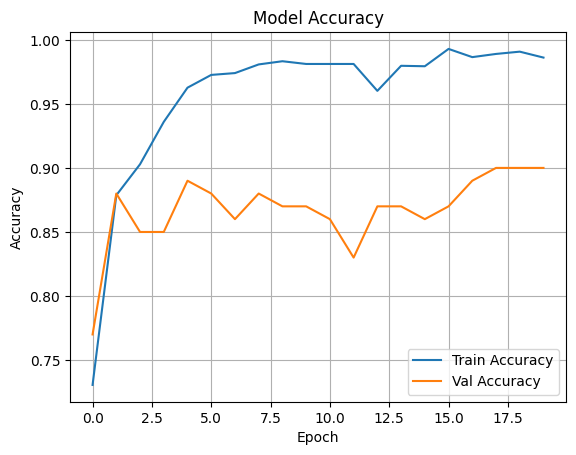

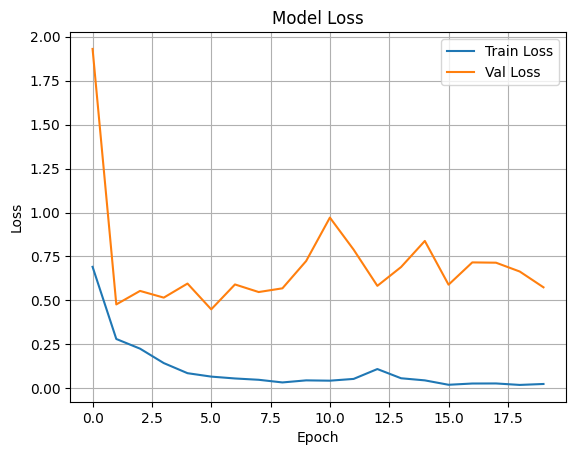

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import os
from PIL import Image
import numpy as np

test_dir = '/content/drive/MyDrive/Dataset_BUSI_Split/test'
categories = ['benign', 'malignant', 'normal']
label_dict = {'benign': 0, 'malignant': 1, 'normal': 2}

test_paths = []
test_labels = []

for label in categories:
    for filename in os.listdir(os.path.join(test_dir, label)):
        if filename.endswith('.png'):
            test_paths.append(os.path.join(test_dir, label, filename))
            test_labels.append(label_dict[label])

# Load and preprocess test images
X_test = []
for path in test_paths:
    img = Image.open(path).convert('RGB')
    img = img.resize((224, 224))
    img_array = np.array(img)
    img_array = preprocess_input(img_array)
    X_test.append(img_array)

X_test = np.array(X_test)
y_test = np.array(test_labels)


In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"✅ Test Accuracy: {test_acc:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 10s/step - loss: 0.7473 - sparse_categorical_accuracy: 0.9020
✅ Test Accuracy: 0.8644


4/4 ━━━━━━━━━━━━━━━━━━━━ 49s 11s/step


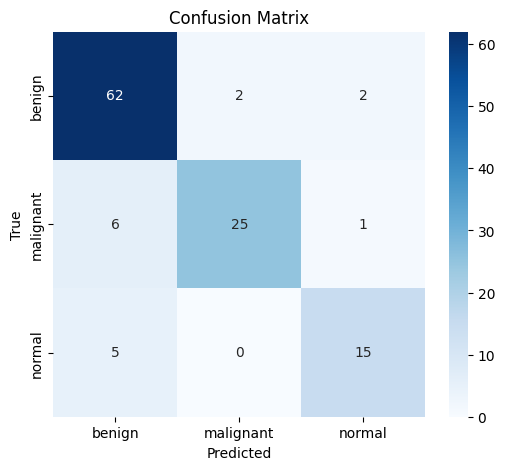

Classification Report:

              precision    recall  f1-score   support

      benign       0.85      0.94      0.89        66
   malignant       0.93      0.78      0.85        32
      normal       0.83      0.75      0.79        20

    accuracy                           0.86       118
   macro avg       0.87      0.82      0.84       118
weighted avg       0.87      0.86      0.86       118



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred_labels, target_names=categories))


4/4 ━━━━━━━━━━━━━━━━━━━━ 42s 10s/step


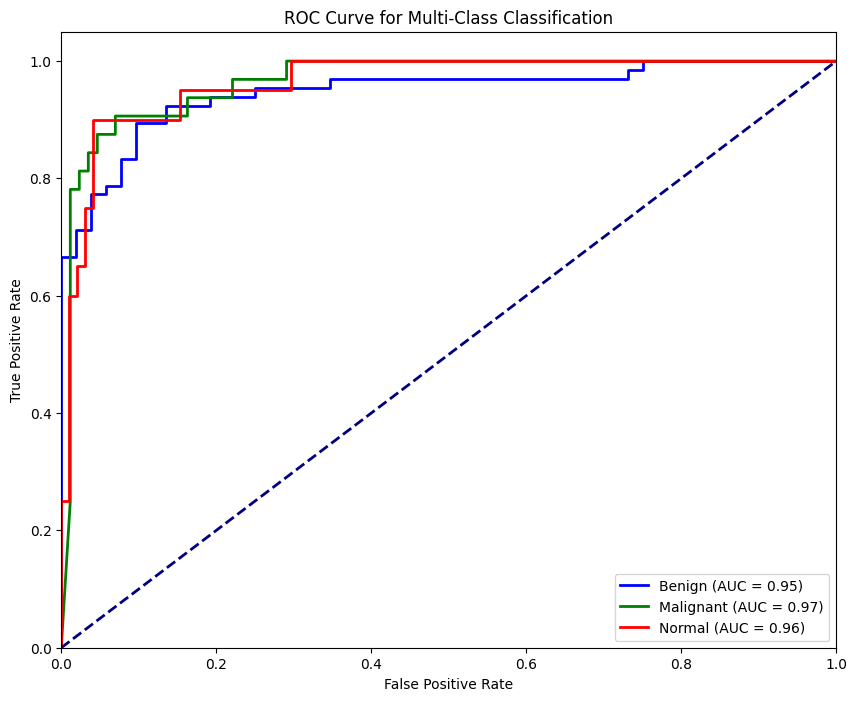

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

# Binarize the true labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # One-hot encoding for multiclass
y_pred_bin = model.predict(X_test)

# Calculate ROC for each class
fpr, tpr, _ = roc_curve(y_test_bin[:, 0], y_pred_bin[:, 0])
roc_auc = auc(fpr, tpr)

fpr1, tpr1, _ = roc_curve(y_test_bin[:, 1], y_pred_bin[:, 1])
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(y_test_bin[:, 2], y_pred_bin[:, 2])
roc_auc2 = auc(fpr2, tpr2)

# Plot ROC curves
plt.figure(figsize=(10, 8))

plt.plot(fpr, tpr, color='blue', lw=2, label=f'Benign (AUC = {roc_auc:.2f})')
plt.plot(fpr1, tpr1, color='green', lw=2, label=f'Malignant (AUC = {roc_auc1:.2f})')
plt.plot(fpr2, tpr2, color='red', lw=2, label=f'Normal (AUC = {roc_auc2:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc='lower right')
plt.show()


Trying RESNET101 with 10-epoch only

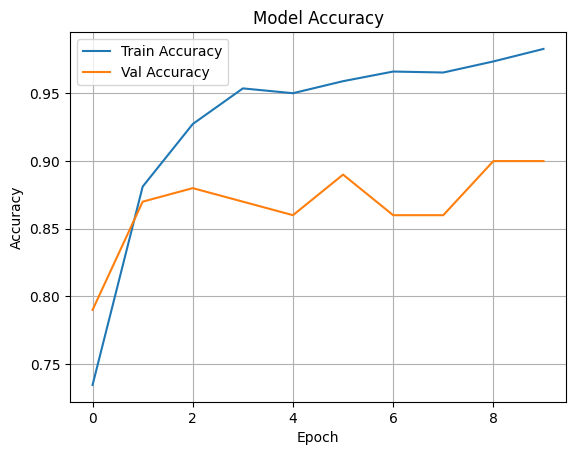

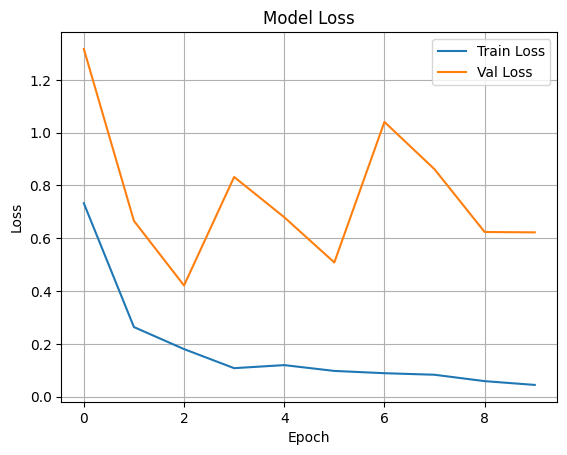

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import os
from PIL import Image
import numpy as np

test_dir = '/content/drive/MyDrive/Dataset_BUSI_Split/test'
categories = ['benign', 'malignant', 'normal']
label_dict = {'benign': 0, 'malignant': 1, 'normal': 2}

test_paths = []
test_labels = []

for label in categories:
    for filename in os.listdir(os.path.join(test_dir, label)):
        if filename.endswith('.png'):
            test_paths.append(os.path.join(test_dir, label, filename))
            test_labels.append(label_dict[label])

# Load and preprocess test images
X_test = []
for path in test_paths:
    img = Image.open(path).convert('RGB')
    img = img.resize((224, 224))
    img_array = np.array(img)
    img_array = preprocess_input(img_array)
    X_test.append(img_array)

X_test = np.array(X_test)
y_test = np.array(test_labels)


In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"✅ Test Accuracy: {test_acc:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 34s 8s/step - loss: 0.6677 - sparse_categorical_accuracy: 0.8773
✅ Test Accuracy: 0.8729


4/4 ━━━━━━━━━━━━━━━━━━━━ 37s 8s/step


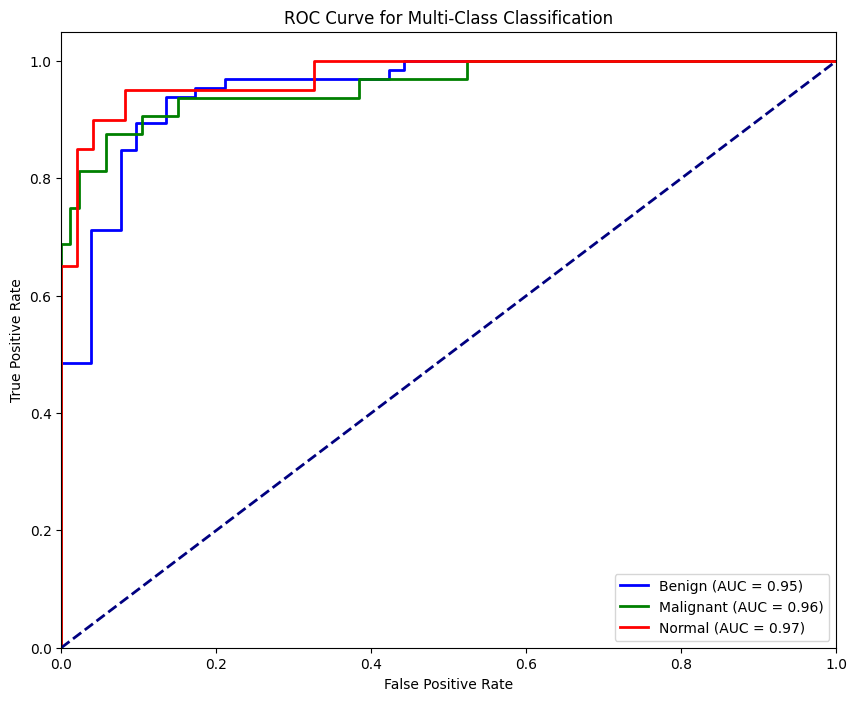

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

# Binarize the true labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # One-hot encoding for multiclass
y_pred_bin = model.predict(X_test)

# Calculate ROC for each class
fpr, tpr, _ = roc_curve(y_test_bin[:, 0], y_pred_bin[:, 0])
roc_auc = auc(fpr, tpr)

fpr1, tpr1, _ = roc_curve(y_test_bin[:, 1], y_pred_bin[:, 1])
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(y_test_bin[:, 2], y_pred_bin[:, 2])
roc_auc2 = auc(fpr2, tpr2)

# Plot ROC curves
plt.figure(figsize=(10, 8))

plt.plot(fpr, tpr, color='blue', lw=2, label=f'Benign (AUC = {roc_auc:.2f})')
plt.plot(fpr1, tpr1, color='green', lw=2, label=f'Malignant (AUC = {roc_auc1:.2f})')
plt.plot(fpr2, tpr2, color='red', lw=2, label=f'Normal (AUC = {roc_auc2:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc='lower right')
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import numpy as np
import random
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


In [ ]:
image_size = (224, 224)  # Resize to EfficientNetB0 input size
train_dir = '/content/drive/MyDrive/Dataset_BUSI_Split/train'
categories = ['benign', 'malignant', 'normal']

train_paths = []
train_labels = []

for label in categories:
    folder_path = os.path.join(train_dir, label)
    for image_file in os.listdir(folder_path):
        if image_file.endswith('.png'):
            train_paths.append(os.path.join(folder_path, image_file))
            train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels, random_state=42)


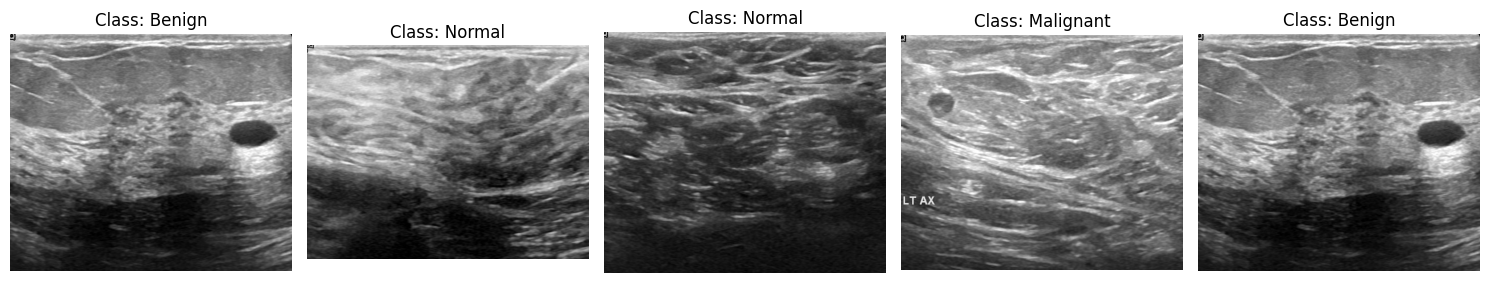

In [ ]:
def show_images_from_paths(paths, labels, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        idx = random.randint(0, len(paths) - 1)
        img = Image.open(paths[idx])
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Class: {labels[idx].capitalize()}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_images_from_paths(train_paths, train_labels)


In [ ]:
train_paths_split, val_paths, train_labels_split, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.15, random_state=42, stratify=train_labels
)


In [ ]:
def load_and_preprocess_images(image_paths):
    images = []
    for path in image_paths:
        img = load_img(path, target_size=image_size)
        img_array = img_to_array(img)
        img_array = preprocess_input(img_array)
        images.append(img_array)
    return np.array(images)

X_train = load_and_preprocess_images(train_paths_split)
X_val = load_and_preprocess_images(val_paths)

label_dict = {'benign': 0, 'malignant': 1, 'normal': 2}
y_train = np.array([label_dict[label] for label in train_labels_split])
y_val = np.array([label_dict[label] for label in val_labels])


In [ ]:
from PIL import ImageEnhance, ImageOps
from tqdm import tqdm

augmented_images = []
augmented_labels = []

for i in tqdm(range(len(train_paths_split))):
    img = Image.open(train_paths_split[i]).convert('RGB')
    label = train_labels_split[i]

    img = img.resize((224, 224))

    augmented_images.append(preprocess_input(np.array(img)))
    augmented_labels.append(label_dict[label])

    enhancer = ImageEnhance.Brightness(img)
    bright_img = enhancer.enhance(1.5)
    augmented_images.append(preprocess_input(np.array(bright_img)))
    augmented_labels.append(label_dict[label])

    enhancer = ImageEnhance.Contrast(img)
    contrast_img = enhancer.enhance(1.3)
    augmented_images.append(preprocess_input(np.array(contrast_img)))
    augmented_labels.append(label_dict[label])

    rotated_img = img.rotate(20)
    augmented_images.append(preprocess_input(np.array(rotated_img)))
    augmented_labels.append(label_dict[label])

    flipped_img = ImageOps.mirror(img)
    augmented_images.append(preprocess_input(np.array(flipped_img)))
    augmented_labels.append(label_dict[label])

X_train_augmented = np.array(augmented_images)
y_train_augmented = np.array(augmented_labels)


100%|██████████| 562/562 [00:11<00:00, 49.57it/s]


In [ ]:
val_images = []
for path in tqdm(val_paths):
    img = Image.open(path).convert('RGB')
    img = img.resize((224, 224))
    img_array = np.array(img)
    img_array = preprocess_input(img_array)
    val_images.append(img_array)

X_val = np.array(val_images)
y_val = np.array([label_dict[label] for label in val_labels])


100%|██████████| 100/100 [00:02<00:00, 43.67it/s]


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_augmented),
    y=y_train_augmented
)

class_weights_dict = dict(enumerate(class_weights))


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

for layer in base_model.layers:
    layer.trainable = False

     # Unfreeze the last 10 layers of ResNet101
for layer in base_model.layers[-10:]:
    layer.trainable = True
for i, layer in enumerate(base_model.layers[-10:]):
    layer.trainable = True
    print(f"Unfroze layer {i}: {layer.name}")

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = AdamW(learning_rate=0.001, weight_decay=1e-5)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Unfroze layer 0: block7a_se_squeeze
Unfroze layer 1: block7a_se_reshape
Unfroze layer 2: block7a_se_reduce
Unfroze layer 3: block7a_se_expand
Unfroze layer 4: block7a_se_excite
Unfroze layer 5: block7a_project_conv
Unfroze layer 6: block7a_project_bn
Unfroze layer 7: top_conv
Unfroze layer 8: top_bn
Unfroze layer 9: top_activation


In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

def step_decay(epoch, lr):
    drop_rate = 0.7
    epochs_drop = 5
    if epoch != 0 and epoch % epochs_drop == 0:
        return lr * drop_rate
    return lr

lr_scheduler = LearningRateScheduler(step_decay, verbose=1)


In [ ]:
batch_size = 32
epochs = 20
steps_per_epoch = int(len(X_train_augmented) / batch_size)

history = model.fit(
    X_train_augmented, y_train_augmented,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[lr_scheduler],
    class_weight=class_weights_dict
)



Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - loss: 0.7454 - sparse_categorical_accuracy: 0.6464 - val_loss: 0.6731 - val_sparse_categorical_accuracy: 0.7300 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step - loss: 0.2682 - sparse_categorical_accuracy: 0.8817 - val_loss: 0.3755 - val_sparse_categorical_accuracy: 0.8100 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 213s 2s/step - loss: 0.1921 - sparse_categorical_accuracy: 0.9221 - val_loss: 0.3393 - val_sparse_categorical_accuracy: 0.9200 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - loss: 0.1225 - sparse_categorical_accuracy: 0.9515 - val_los

In [ ]:
model.save("/content/drive/MyDrive/efficient_20s_88step.h5")
print("✅ Model saved to Google Drive!")

✅ Model saved to Google Drive!


In [ ]:
import os
from PIL import Image
import numpy as np

test_dir = '/content/drive/MyDrive/Dataset_BUSI_Split/test'
categories = ['benign', 'malignant', 'normal']
label_dict = {'benign': 0, 'malignant': 1, 'normal': 2}

test_paths = []
test_labels = []

for label in categories:
    for filename in os.listdir(os.path.join(test_dir, label)):
        if filename.endswith('.png'):
            test_paths.append(os.path.join(test_dir, label, filename))
            test_labels.append(label_dict[label])

# Load and preprocess test images
X_test = []
for path in test_paths:
    img = Image.open(path).convert('RGB')
    img = img.resize((224, 224))
    img_array = np.array(img)
    img_array = preprocess_input(img_array)
    X_test.append(img_array)

X_test = np.array(X_test)
y_test = np.array(test_labels)


In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 0.6292 - sparse_categorical_accuracy: 0.9025
Test Loss: 0.7710
Test Accuracy: 0.8814


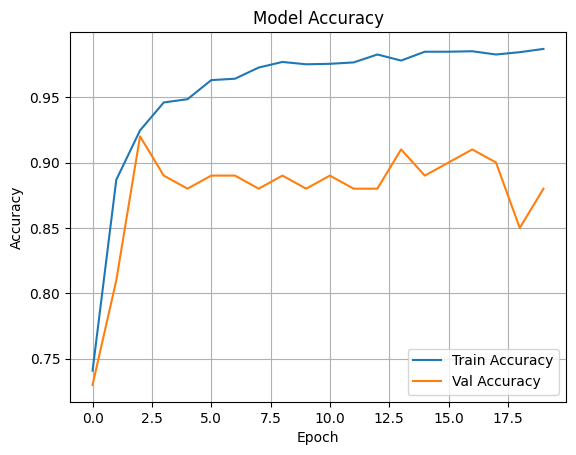

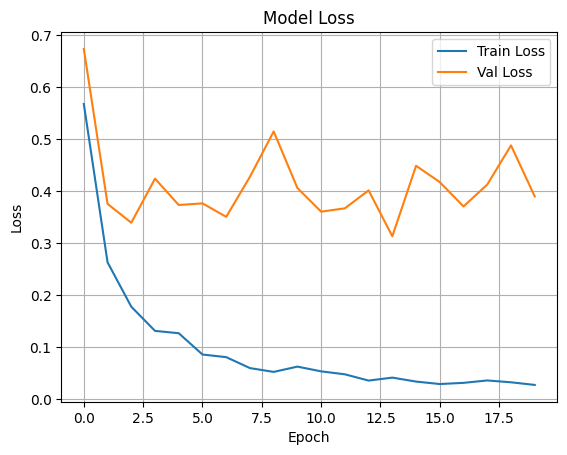

In [ ]:
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step


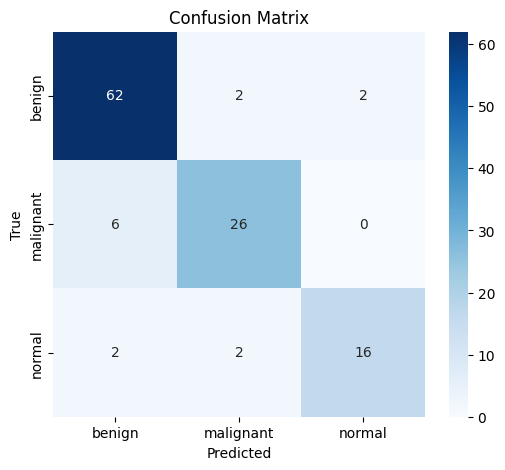

Classification Report:

              precision    recall  f1-score   support

      benign       0.89      0.94      0.91        66
   malignant       0.87      0.81      0.84        32
      normal       0.89      0.80      0.84        20

    accuracy                           0.88       118
   macro avg       0.88      0.85      0.86       118
weighted avg       0.88      0.88      0.88       118



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred_labels, target_names=categories))


4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


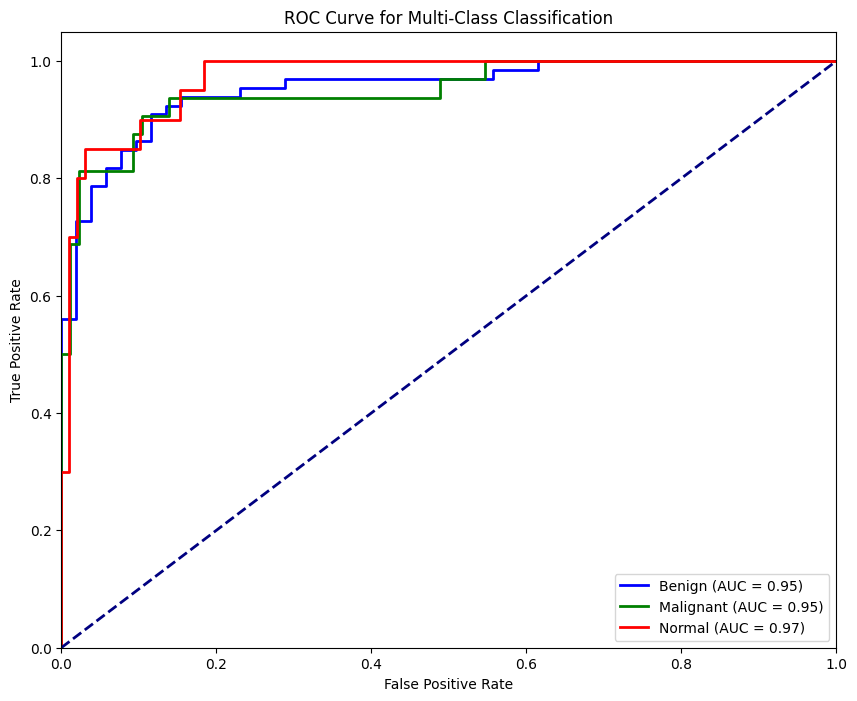

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

# Binarize the true labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # One-hot encoding for multiclass
y_pred_bin = model.predict(X_test)

# Calculate ROC for each class
fpr, tpr, _ = roc_curve(y_test_bin[:, 0], y_pred_bin[:, 0])
roc_auc = auc(fpr, tpr)

fpr1, tpr1, _ = roc_curve(y_test_bin[:, 1], y_pred_bin[:, 1])
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(y_test_bin[:, 2], y_pred_bin[:, 2])
roc_auc2 = auc(fpr2, tpr2)

# Plot ROC curves
plt.figure(figsize=(10, 8))

plt.plot(fpr, tpr, color='blue', lw=2, label=f'Benign (AUC = {roc_auc:.2f})')
plt.plot(fpr1, tpr1, color='green', lw=2, label=f'Malignant (AUC = {roc_auc1:.2f})')
plt.plot(fpr2, tpr2, color='red', lw=2, label=f'Normal (AUC = {roc_auc2:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc='lower right')
plt.show()
